# NBA Player Performance Trend Analysis
**By Sibhi Sakthivel**

# 1) Introduction

Even the best athletes in the world have an off night eventually, sometimes even a few bad games in a row.

# 2) Research Question

In this study, we are going to be designing, executing, and sharing my findings on trends in NBA player scoring performances. Specifically, we are going to be addressing the question:

**Do sustained departures from a player’s long-term scoring expectation correlate with an increased likelihood of subsequent over- or under-performance relative to that expectation?**

In other words, we are analyzing whether a period of consecutive games with poor scoring performances is correlated with a higher chance of an upcoming game exceeding baseline scoring performance, and vice versa.

# 3) Context, Assumptions, and Confounding Factors

NBA player performance is influenced by several factors, including opponent matchup and teammate availability. These two factors can have a significant impact on a player's efficiency, usage, and minutes played, which can influence how well a player plays and the statistics they record.

Because opponent strength and lineup composition are not randomly assigned, they represent potential confounding variables when analyzing short-term performance trends. Apparent performance “reversion” or “continuation” may reflect changes in these factors rather than intrinsic performance dynamics. For this reason, the analysis proceeds in stages. Initial results examine the raw relationship between sustained performance deviations and subsequent outcomes, followed by conditioned analyses that explicitly account for matchup difficulty and teammate availability to assess robustness.

This analysis is observational and does not attempt to establish causal effects. Instead, it aims to evaluate whether commonly cited performance narratives retain predictive or descriptive value once key contextual factors are considered.

# 3) Data Overview

### Unit of Analysis

The primary unit of analysis in this study is a player–game observation, where each row represents an individual player’s scoring performance in a single NBA game.

### Data Source

The dataset was constructed from the publicly available NBA API, in which we retrieved game-level data including player box score statistics, game context variables, teammate availability, and opponent matchup metrics.

### Data Scope

The analysis focuses on regular-season games from the 2024–25 NBA season, with players required to meet minimum participation thresholds to ensure stable baseline estimates.

For clarity and interpretability, this study focuses exclusively on player scoring performance, measured using points scored per game. While player performance is multi-dimensional, scoring provides a clear, widely understood outcome that aligns with common performance narratives and decision-making contexts.

Additionally, the analysis is conducted at the individual player level, using a single high-usage player as a case study. This design choice allows for detailed examination of performance dynamics without conflating effects across heterogeneous player roles, play styles, and usage profiles.

While this limits the generalizability of results, the framework is designed to be extensible to additional players and performance metrics in future work.

### Data Limitations

Several limitations are inherent in the dataset. Defensive matchup difficulty is represented using team-level and positional defensive metrics, which serve as coarse proxies and do not capture individual on-ball defensive assignments or in-game matchup adjustments.

Teammate availability is approximated using minutes-based thresholds, where high-usage teammates are considered “available” if they play at least a fixed proportion of their season-average minutes. While this approach captures major role-level changes, it may not fully reflect partial usage restrictions, staggered rotations, or in-game context that affects effective player involvement.

In [1]:
# Connect to database
from sqlalchemy import create_engine
import pandas as pd

DB_USER = "admin"
DB_PASSWORD = "admin"
DB_HOST = "localhost"
DB_PORT = 5433
DB_NAME = "nba_db"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# Player box score data
pbs = pd.read_sql(
    """
    SELECT *
    FROM player_box_scores.player_boxscores
    """,
    engine
)

# Team box score data
tbs = pd.read_sql(
    """
    SELECT *
    FROM team_box_scores.league_gamelog
    """,
    engine
)

print(pbs.columns, tbs.columns)

Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade',
       'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade',
       'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive',
       'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks',
       'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints', 'game_id'],
      dtype='object') Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE',
       'SEASON', 'SEASON_TYPE'],
      dtype='object')


# 4) Methodology

### Baseline Scoring Performance

A player’s baseline scoring performance is defined as their season-average points per game across all regular-season games played up to a given point in the season. This baseline is intended to represent a player’s long-term expected scoring output under typical conditions, abstracting away short-term variance and game-to-game noise.

By anchoring performance deviations to a long-term expectation, the analysis focuses on whether sustained departures from expected scoring levels are associated with short-term reversion or continuation in subsequent games.

Rolling-window baselines were considered but not used in order to avoid conflating short-term form with long-term expectation, which is central to the research question.

### Performance Deviation

For each game, a player’s performance deviation is defined as the difference between their observed scoring output in that game and their season-average scoring baseline. This deviation represents how much a player over- or under-performed relative to their long-term expected scoring level.

Positive deviations indicate games in which the player scored more points than their season average, while negative deviations indicate games in which the player scored fewer points than expected. By preserving the direction of the deviation, this definition allows performance to be evaluated not only in terms of magnitude but also in terms of whether a player exceeded or fell short of their baseline expectation.

This measure serves as the fundamental building block for identifying sustained periods of over- or under-performance across consecutive games, which are examined in subsequent sections.

### Sustained Performance Streaks

Each game is first classified as an overperformance or underperformance based on whether the player’s scoring output exceeds or falls below their season-average baseline. Using this classification, a sustained performance streak is defined as a sequence of consecutive games in which the player consistently overperforms or underperforms relative to baseline.

In this study, a streak is considered to occur when a player records at least three consecutive overperforming or underperforming games. The length of the streak corresponds to the number of consecutive games meeting this criterion. This framework allows performance trends to be represented as discrete states that can be used to evaluate how the likelihood of subsequent over- or underperformance changes as streak length increases.

### Outcome Definition

The primary outcome of interest is the player’s scoring performance in the game immediately following a sustained performance streak. For each identified streak, the subsequent game is classified based on whether the player’s scoring output exceeds or falls below their season-average baseline.

This outcome is represented as a binary indicator, where an overperformance corresponds to scoring above baseline and an underperformance corresponds to scoring below baseline. This formulation allows the probability of over- or underperformance in the next game to be estimated conditional on the length and direction of the preceding streak.

### Contextual Adjustments

Opponent difficulty is represented using team-level defensive metrics, which serve as coarse proxies for overall matchup strength. These measures are used to stratify analyses and assess whether observed performance relationships persist across varying levels of opponent defensive quality.

Teammate availability is approximated using minutes-based thresholds. High-usage teammates are considered available in a given game if they play at least a fixed proportion of their season-average minutes. This approach is intended to capture major role-level shifts while remaining interpretable and reproducible.

These contextual variables are not used to redefine performance baselines or streaks, but are incorporated in subsequent analyses to evaluate whether observed performance patterns are robust to changes in game context.

# 5) Analysis



### Dataset Construction

We'll begin by constructing a dataset from the database that include all the data types we'll be using in this analysis. These data types include:
- Game date/ID
- Player name/ID
- Team name/ID
- Player points scored
- Player season average points
- Player point deviation from season average
- Scoring performance over/under season average flag

In [2]:
dataset = """
WITH teams AS(
    SELECT 
        "TEAM_ID" AS team_id, 
        "TEAM_ABBREVIATION" AS team, 
        "GAME_ID" AS game_id,
        "GAME_DATE" AS game_date, 
        "MATCHUP" AS matchup, 
        "PTS" AS pts,
        AVG("PTS") OVER (
            PARTITION BY RIGHT("MATCHUP", 3)
            ORDER BY "GAME_DATE"
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS opp_pts_allowed
    FROM team_box_scores.league_gamelog t
)

SELECT 
    t.game_id,
    t.game_date,
    p."personId" AS player_id,
    CONCAT_WS(' ', p."firstName", p."familyName") AS player_name,
    p."teamId" AS team_id,
    RIGHT(t.matchup, 3) AS team,
    p.points AS pts,
    AVG(p.points) OVER(
        PARTITION BY  p."personId"
        ORDER BY t.game_date
        ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ) AS szn_avg_pts,
    p.points
        - AVG(p.points) OVER(
            PARTITION BY  p."personId"
            ORDER BY t.game_date
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS deviation,
    CASE
        WHEN p.points
           > AVG(p.points) OVER (
                 PARTITION BY p."personId"
                 ORDER BY t.game_date
                 ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
             )
        THEN 1
        ELSE 0
    END AS over_flag,
    LEFT(t.matchup, 3) AS opp,
    t.opp_pts_allowed
FROM teams t
JOIN player_box_scores.player_boxscores p
    ON p."teamId" <> t.team_id
        AND p."gameId" = t.game_id
ORDER BY player_id, game_date
"""

data = pd.read_sql(dataset, engine)
analysis_dataset = data[data["player_name"] == "Jamal Murray"]
analysis_dataset.head()

,game_id,game_date,player_id,player_name,team_id,team,pts,szn_avg_pts,deviation,over_flag,opp,opp_pts_allowed
6980,22400075,2024-10-24,1627750,Jamal Murray,1610612743,DEN,12,NaN,NaN,0,OKC,NaN
6981,22400087,2024-10-26,1627750,Jamal Murray,1610612743,DEN,22,12.00,10.00,1,LAC,102.00
6982,22400107,2024-10-28,1627750,Jamal Murray,1610612743,DEN,17,17.00,0.00,0,TOR,105.50
6983,22400113,2024-10-29,1627750,Jamal Murray,1610612743,DEN,24,17.00,7.00,1,BKN,112.00
6984,22400139,2024-11-01,1627750,Jamal Murray,1610612743,DEN,6,18.75,-12.75,0,MIN,118.75


### Feature Validation & Sanity Checks

Now we'll perform some checks to verify that variables are logical and correctly represent what they are intended to.

(67, 12)
1    67
Name: count, dtype: int64
True
      pts  szn_avg_pts  opp_pts_allowed
6980   12          NaN              NaN
6981   22         12.0            102.0
6982   17         17.0            105.5
       game_date  pts  szn_avg_pts  deviation
7011  2025-01-12   17    19.032258  -2.032258
7031  2025-02-27   20    21.137255  -1.137255
7007  2025-01-04   13    19.629630  -6.629630
True    67
Name: count, dtype: int64


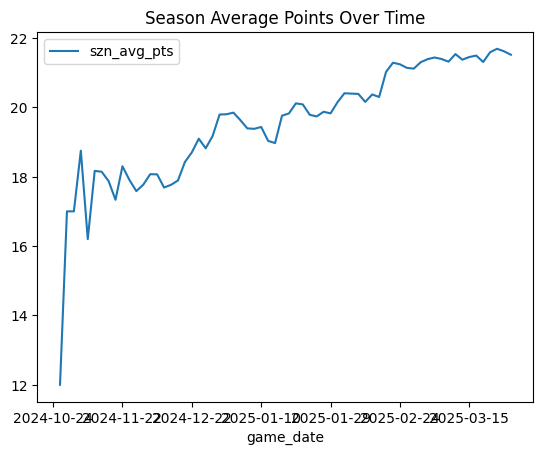

In [8]:
print(analysis_dataset.shape)       # number of games played, number of cols in df
print(analysis_dataset.groupby(     # number of player_id - game_id combos = number of games played
    ["player_id", "game_id"]).size().value_counts()) 

print(analysis_dataset["game_date"].is_monotonic_increasing)                # game dates are ordered correctly
print(analysis_dataset.head(3)[["pts", "szn_avg_pts", "opp_pts_allowed"]])  # first row has point averages

import matplotlib.pyplot as plt

analysis_dataset[["game_date", "szn_avg_pts"]].plot(
    x="game_date",
    y="szn_avg_pts",
    title="Season Average Points Over Time"
)

analysis_dataset["deviation"].describe()    # mean is about 0, 

print(analysis_dataset.sample(3)[["game_date", "pts", "szn_avg_pts", "deviation"]]) # deviation correctly calculated

print((
    (analysis_dataset["pts"] > analysis_dataset["szn_avg_pts"])
    == (analysis_dataset["over_flag"] == 1)
).value_counts())


### Exploratory Data Analysis

First let's observe the distribution of deviations throughout the season.

Text(0.5, 1.0, 'Point Deviation from Season Baseline Over Time')

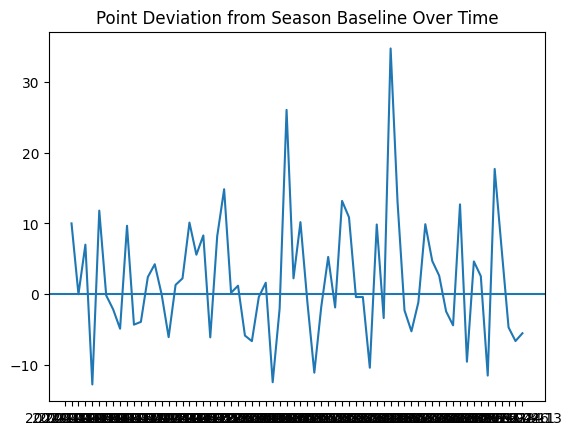

In [9]:
plt.figure()
plt.plot(analysis_dataset["game_date"], analysis_dataset["deviation"])
plt.axhline(0)
plt.title("Point Deviation from Season Baseline Over Time")

Now let's explore when hot or cold-streaks occurr.